In [1]:
import numpy as np
import pandas as pd
from IPython.display import display

import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
train = pd.read_parquet("data/tidy/train.parquet")

# **Validação da base**

---

- Os minimos e máximos das variáveis fazem sentido?
- Quais colunas tem dados faltantes?
- Existem amostras duplicadas?


In [5]:
train.describe().loc[["min", "max"]].T

,min,max
NU_IDADE,10.0,9.400000e+01
TP_ESTADO_CIVIL,0.0,4.000000e+00
TP_COR_RACA,0.0,5.000000e+00
TP_NACIONALIDADE,0.0,4.000000e+00
TP_ST_CONCLUSAO,1.0,4.000000e+00
TP_ANO_CONCLUIU,0.0,1.300000e+01
TP_ESCOLA,1.0,3.000000e+00
TP_ENSINO,1.0,2.000000e+00
CO_ESCOLA,11000058.0,5.308802e+07
TP_DEPENDENCIA_ADM_ESC,1.0,4.000000e+00


In [19]:
cond = train.isna().sum() > 0

train.columns[cond]

Index(['NU_IDADE', 'NO_MUNICIPIO_NASCIMENTO', 'SG_UF_NASCIMENTO', 'TP_ENSINO',
       'CO_ESCOLA', 'NO_MUNICIPIO_ESC', 'SG_UF_ESC', 'TP_DEPENDENCIA_ADM_ESC',
       'TP_LOCALIZACAO_ESC', 'TP_SIT_FUNC_ESC', 'NU_NOTA_CN', 'NU_NOTA_CH',
       'NU_NOTA_LC', 'NU_NOTA_MT', 'TP_STATUS_REDACAO', 'NU_NOTA_REDACAO'],
      dtype='object')

In [23]:
train.duplicated().any()

False

---
- Qual a nota das pessoas que faltaram nas provas ? 

    - TP_PRESENCA_CN
    - TP_PRESENCA_CH
    - TP_PRESENCA_LC
    - TP_PRESENCA_MT

In [24]:
tp_mapping = {"TP_PRESENCA_CN": "NU_NOTA_CN",
              "TP_PRESENCA_CH": "NU_NOTA_CH",
              "TP_PRESENCA_LC": "NU_NOTA_LC",
              "TP_PRESENCA_MT": "NU_NOTA_MT"}

# 0 significa faltou e 2 eliminado
for presence, nota in tp_mapping.items():
    aux = (train.query(f"{presence} == 0 | {presence} == 2")
                .loc[:,nota]
                .isna()
                .all())
    print(f"{presence}: {aux}")

TP_PRESENCA_CN: True
TP_PRESENCA_CH: True
TP_PRESENCA_LC: True
TP_PRESENCA_MT: True


--- 

- Qual a nota das pessoas que faltaram em 1 dia? 

    - TP_PRESENCA_CN
    - TP_PRESENCA_CH
    - TP_PRESENCA_LC
    - TP_PRESENCA_MT


O enem possuí dois dias de prova. No primeiro dia são aplicadas as provas de Linguagens, Códigos e suas Tecnologias ```TP_PRESENCA_LC```, Ciências Humanas e suas Tecnologias  (```TP_PRESENCA_CH```) e Redação. No segundo dia são aplicadas as provas de Ciências da Natureza e suas Tecnologias (```TP_PRESENCA_CN```) e Matemática e suas Tecnologias  (```TP_PRESENCA_MT```). Isto é, se faltou em um dia as notas daquele dia devem todas estarem zeradas.

In [25]:
day_mapping = {"DAY_ONE":(("TP_PRESENCA_LC", "TP_PRESENCA_CH"), ("NU_NOTA_LC", "NU_NOTA_CH", "NU_NOTA_REDACAO")),
               "DAY_TWO":(("TP_PRESENCA_CN", "TP_PRESENCA_MT"), ("NU_NOTA_CN", "NU_NOTA_MT"))}

for day, val in day_mapping.items():
    (presence1, presence2), (notas) = val
    aux = (train.query(f"({presence1} == 0 | {presence1} == 2) & ({presence2} == 2 | {presence2} == 0)")
                .loc[:,notas]
                .isna()
                .all())
    print(f"{day}:")
    print(f"{aux}\n")

DAY_ONE:
NU_NOTA_LC         True
NU_NOTA_CH         True
NU_NOTA_REDACAO    True
dtype: bool

DAY_TWO:
NU_NOTA_CN    True
NU_NOTA_MT    True
dtype: bool



# **Exemplo**
---
- Qual a distribuição das notas por sexo? 

    - TP_SEXO
    - NU_NOTA_MT
    

In [32]:
train.filter(regex="NU_NOTA").columns

Index(['NU_NOTA_CN', 'NU_NOTA_CH', 'NU_NOTA_LC', 'NU_NOTA_MT',
       'NU_NOTA_REDACAO'],
      dtype='object')

In [33]:
notas_columns = ['NU_NOTA_CN', 'NU_NOTA_CH', 'NU_NOTA_LC', 'NU_NOTA_MT', 'NU_NOTA_REDACAO']

temp = (train.reset_index()
             .melt(id_vars="TP_SEXO", value_vars=notas_columns, var_name="PROVAS", value_name="NOTA"))
temp.head()

,TP_SEXO,PROVAS,NOTA
0,F,NU_NOTA_CN,426.500000
1,F,NU_NOTA_CN,463.000000
2,M,NU_NOTA_CN,381.700012
3,M,NU_NOTA_CN,426.700012
4,M,NU_NOTA_CN,623.700012


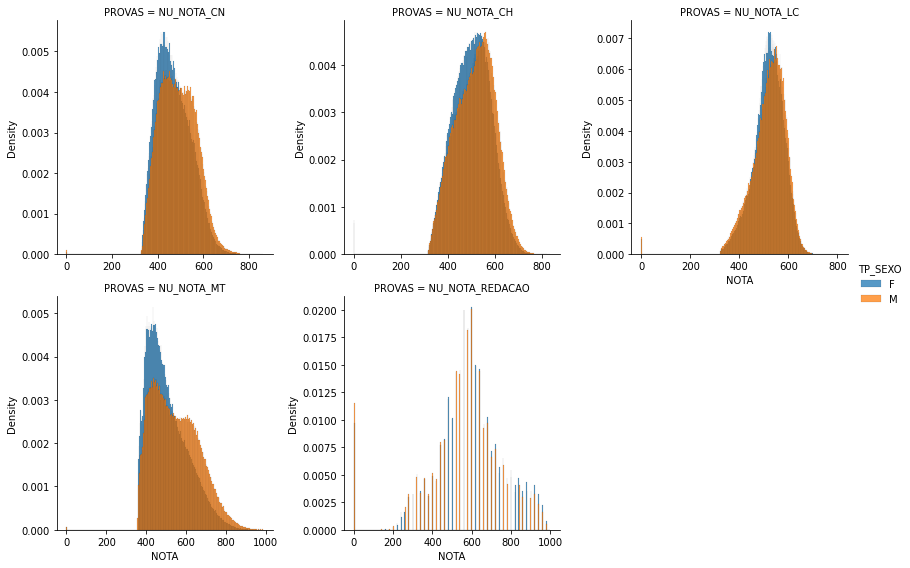

In [35]:
g = sns.FacetGrid(temp, col="PROVAS", hue="TP_SEXO", col_wrap=3, height=4, sharex=False, sharey=False)
g.map_dataframe(sns.histplot, x="NOTA",stat="density")
g.add_legend()
plt.show()

- Calcule uma medida de tendência central e uma medida de dispersão (Calcule para cada grupo).

In [40]:
def iqr(x):
    return x.quantile(0.75) - x.quantile(0.25)

stats = ["mean", "std", "median", iqr, "skew"]

(train.groupby("TP_SEXO", as_index=False)
      .agg({"NU_NOTA_CN":stats, 
            "NU_NOTA_CH":stats,
            "NU_NOTA_LC":stats,
            "NU_NOTA_MT":stats,
            "NU_NOTA_REDACAO":stats})
     .T)

0           1
TP_SEXO                          F           M
NU_NOTA_CN      mean    469.987457  489.297943
                std      73.650955   78.126811
                median  461.100006  485.399994
                iqr     109.200012  120.200012
                skew      0.437027    0.214004
NU_NOTA_CH      mean    501.879059  515.132202
                std      79.762396   85.599432
                median       504.0  521.299988
                iqr     114.300018  123.900024
                skew      -0.27669   -0.437155
NU_NOTA_LC      mean    519.755493  521.620178
                std      62.157821   66.967581
                median  524.099976  529.700012
                iqr      78.299988   87.200012
                skew     -0.740422   -0.872956
NU_NOTA_MT      mean    506.153564   547.96759
                std      100.79433  115.795321
                median  483.700012  534.700012
                iqr     141.700012  181.099976
                skew      0.829805    0.450041
NU_NOTA_REDACAO mean    577.005127  562.471069
                std     187.537191  190.097872
                median       580.0       580.0
                iqr          200.0       180.0
                skew     -0.672589     -0.7546

- Encontre os outliers (utilize alguns dos métodos vistos em aulas).

In [61]:
data_structure = (train.loc[:, notas_columns]
                       .apply(lambda x: (x.mean(), x.std())))
data_structure

,NU_NOTA_CN,NU_NOTA_CH,NU_NOTA_LC,NU_NOTA_MT,NU_NOTA_REDACAO
0,477.814270,507.235748,520.509338,523.10199,571.130615
1,76.090034,82.428574,64.151833,109.07724,188.711166


In [141]:
def z_score(x, data_structure):
    u = data_structure.loc[0, x.name]
    sigma = data_structure.loc[1, x.name]
    return (x - u)/sigma


z_scores = train.loc[:, notas_columns].apply(lambda x: z_score(x,data_structure))
z_scores.columns = [column + "_ZSCORE" for column in z_scores.columns]
z_scores

,NU_NOTA_CN_ZSCORE,NU_NOTA_CH_ZSCORE,NU_NOTA_LC_ZSCORE,NU_NOTA_MT_ZSCORE,NU_NOTA_REDACAO_ZSCORE
0,-0.674389,-0.240642,0.161970,-0.988309,0.576910
1,-0.194694,-0.666465,-0.996220,-1.062568,-0.270946
2,-1.263165,-0.398354,0.157293,0.914013,0.152982
3,-0.671760,-1.981543,-1.189511,-0.147620,0.470928
4,1.917278,1.235788,1.817417,2.587139,1.424767
...,...,...,...,...,...
3311920,0.006383,-0.659186,0.238351,-0.522584,0.152982
3311921,-0.368173,0.634055,0.654551,0.007316,0.152982
3311922,-0.507481,0.338041,0.637405,-0.807703,-1.330767
3311923,NaN,NaN,NaN,NaN,NaN


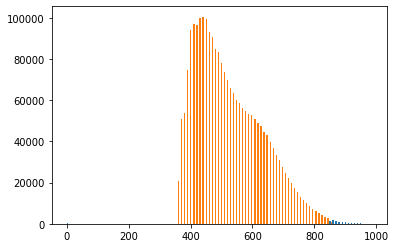

In [143]:
var = "NU_NOTA_MT_ZSCORE"
amostras_a = pd.concat([train, z_scores], axis =1).query(f"{var} > 3 or {var} < -3").loc[:, var.split("_ZSCORE")[0]]
amostras_b = pd.concat([train, z_scores], axis =1).query(f"{var} <= 3 and {var} >= -3").loc[:, var.split("_ZSCORE")[0]]

g = plt.hist([amostras_a, amostras_b], bins=100)

plt.show()

# **Questões** 

---

- Qual a distribuição das notas por cor/raça? 

    - TP_COR_RACA
    
- Calcule uma medida de tendência central e uma medida de dispersão. (Calcule para cada grupo)

- Encontre os outliers (utilize alguns dos métodos vistos em aulas).

---

- Qual a distribuição das notas por estado civil? 

    - TP_ESTADO_CIVIL
    
- Calcule uma medida de tendência central e uma medida de dispersão. (Calcule para cada grupo)

- Encontre os outliers (utilize alguns dos métodos vistos em aulas).

---
- Existe diferença entre a nota das pessoas que precisam de recurso?

    - IN_SEM_RECURSO

---
    
- Alunos que fizeram a prova em sala particular performam melhor que o resto? 

    - IN_SALA_INDIVIDUAL

---    
- Existe diferença entre a nota dos jovens e idosos?

    - IN_IDOSO

---
- Existe diferença entre as notas de quem escolheu inglês ou espanhol?

    - TP_LINGUA
    

---

- Ter alguma deficiência impacta na nota?

    - IN_BAIXA_VISAO 
    - IN_CEGUEIRA 
    - IN_SURDEZ 
    - IN_DEFICIENCIA_AUDITIVA 
    - IN_SURDO_CEGUEIRA
    - IN_DEFICIENCIA_FISICA
    - IN_DEFICIENCIA_MENTAL
    - IN_DEFICIT_ATENCAO
    - IN_DISLEXIA
    - IN_DISCALCULIA
    - IN_AUTISMO
    - IN_VISAO_MONOCULAR
    - IN_OUTRA_DEF

---
- Como as seguintes variáveis estão relacionadas?

    - IN_CEGUEIRA 
    - IN_BRAILLE
    - IN_LIBRAS
    

---
- Analise as perguntas. Você acredita que alguma delas pode te ajudar a entender os resultados das notas nas provas? 

```python
['Q001', 'Q002', 'Q003', 'Q004', 'Q005', 'Q006', 'Q007', 'Q008', 'Q009',
 'Q010', 'Q011', 'Q012', 'Q013', 'Q014', 'Q015', 'Q016', 'Q017', 'Q018',
 'Q019', 'Q020', 'Q021', 'Q022', 'Q023', 'Q024', 'Q025']
```